In [135]:
import dask.dataframe as dd
from nltk.corpus import stopwords
import emoji
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score

In [136]:
%%time
needed_columns = ['review_description', 'rating']
ddf = dd.read_csv('Data/Ola Customer Reviews.csv',usecols=needed_columns, dtype = {'rating':'int32'})

CPU times: user 32.6 ms, sys: 0 ns, total: 32.6 ms
Wall time: 30.8 ms


In [137]:
ddf.to_parquet('Data/Ola Customer Reviews.parquet', engine = 'pyarrow')

In [138]:
%%time
df = dd.read_parquet('Data/Ola Customer Reviews.parquet', engine = 'pyarrow',gather_statistics=True)

CPU times: user 32.6 ms, sys: 35 μs, total: 32.6 ms
Wall time: 31.2 ms


In [139]:
df = df.reset_index()

In [140]:
%%time
df.shape[0].compute() # no. of rows

CPU times: user 65 ms, sys: 8.02 ms, total: 73 ms
Wall time: 71.5 ms


357698

In [141]:
df.head()

,index,review_description,rating
0,0,"The map in Ola is so messed up, i have to pay ...",1
1,1,Deepak Kumar.... 🙏🙏🙏🙏🙏],5
2,2,Such aa irresponsible app more then I waiting ...,1
3,3,Worst,1
4,4,Too much expensive .. try UBer... They are pro...,1


In [142]:
%%time
df = df.dropna()

CPU times: user 693 μs, sys: 4 μs, total: 697 μs
Wall time: 701 μs


In [143]:
def preprocess(text):
    text = text.lower().strip()
    extracted_emojis = ' '.join(char for char in text if char in emoji.EMOJI_DATA)
    important_words = {'but', 'than'}
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english') or word in important_words])
    return text +" "+ extracted_emojis

In [144]:
%%time
ddf['review_description'] = ddf['review_description'].apply(preprocess, meta=('review_description', 'str'))

CPU times: user 3.11 ms, sys: 0 ns, total: 3.11 ms
Wall time: 3.12 ms


In [145]:
df.head()

,index,review_description,rating
0,0,"The map in Ola is so messed up, i have to pay ...",1
1,1,Deepak Kumar.... 🙏🙏🙏🙏🙏],5
2,2,Such aa irresponsible app more then I waiting ...,1
3,3,Worst,1
4,4,Too much expensive .. try UBer... They are pro...,1


In [146]:
def analyze_sentiment(text,competitors):

    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    competitor_mentioned = any(comp in text.lower() for comp in competitors)

    if competitor_mentioned and ("expensive" in text.lower() or "better" in text.lower() or "extra charge" in text.lower() or 'hangs' in text.lower()
                                 or "irresponsible" in text.lower() or "demanding" in text.lower()):
        return "negative"

    if polarity > 0:
        return 'positive'
    if polarity < 0:
        return 'negative'
    else:
        return 'neutral'
    

In [147]:
from functools import partial

In [148]:
analyze_sentiment_partial = partial(analyze_sentiment,competitors='uber')

In [149]:
df['review_description'] = df['review_description'].astype('string').astype('object')

In [150]:
%%time

df['sentiment'] = df['review_description'].map_partitions(
    lambda x: x.apply(analyze_sentiment_partial)
)

CPU times: user 2.34 ms, sys: 0 ns, total: 2.34 ms
Wall time: 2.33 ms


In [151]:
df['review_description'] = df['review_description'].astype("string[pyarrow]")

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
%%time
sentiment_counts = df.groupby('sentiment')['sentiment'].count().compute()

CPU times: user 1min 54s, sys: 397 ms, total: 1min 54s
Wall time: 1min 54s


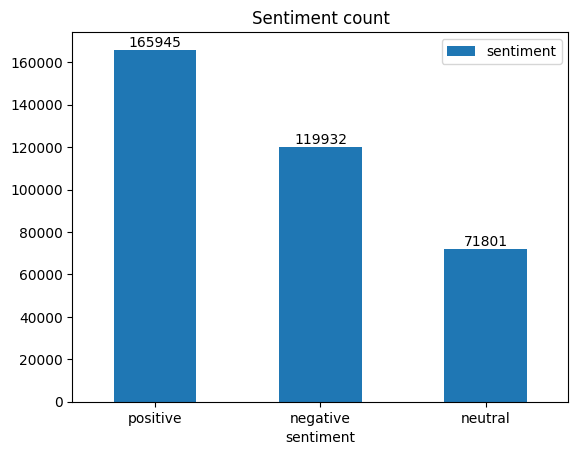

In [154]:
sentiment_counts = sentiment_counts.sort_values(ascending=False)
ax = sentiment_counts.plot(kind = 'bar',legend = True)
for container in ax.containers:
    ax.bar_label(container, padding=0.3)
plt.title("Sentiment count")
plt.xticks(rotation = 0)
plt.show()

In [155]:
tfidf = TfidfVectorizer(max_features=5)
x_text = tfidf.fit_transform(df['review_description'])
y = df['sentiment']

In [174]:
df = df.drop(columns=['index'])

In [173]:
x_text.toarray()

array([[ 0.35939868,  0.19076307,  0.19269652,  0.87539174,  0.17606647,
        -0.95747673],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.20243019],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.95747673],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.20243019],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.95747673],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.20243019]])

In [175]:
scaler = StandardScaler()
x_rating = scaler.fit_transform(df[['rating']])

KeyboardInterrupt: 

In [ ]:
x = hstack([x_text,x_rating])

In [170]:
print(df.columns)

Index(['index', 'review_description', 'rating', 'sentiment'], dtype='object')


In [161]:
x_train, x_text, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LogisticRegression(multi_class = 'multinomial', solver = 'saga', max_iter=100)
model.fit(x_train,y_train)

KeyError: 'key of type tuple not found and not a MultiIndex'